In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, auc,
                             classification_report)
from sklearn.model_selection import train_test_split

In [2]:
df1 = pd.read_csv('https://lms.skillfactory.ru/asset-v1:SkillFactory+MIPTDS+SEPT22+type@asset+block@train.csv', sep=',')

In [3]:
df = df1.copy()

In [4]:
display(df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Предобработка данных

In [5]:
# Проверим, есть ли в датасете незаполненные значения
# Мы видим, что в столбце Cabin, Age, Embarked есть пропуски 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# Удалим столбец Cabin из-за огромного количества пропусков и столбцы PassengerId, Name, Ticket, 
# Embarked так как они не понадобятся для обучения модели
df = df.drop(['Cabin','PassengerId', 'Name', 'Ticket', 'Embarked',], axis=1)

In [7]:
# Удалим строки, в которых пропущено значение Age
df.dropna(inplace = True)

In [8]:
# Заменим значения в признаке Sex на 0(male) и 1(female)
df.loc[df.Sex == 'male', 'Sex'] = 0
df.loc[df.Sex == 'female', 'Sex'] = 1

In [9]:
# Все пропуски заполнены
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
dtype: int64

<Axes: title={'center': 'Count (target)'}>

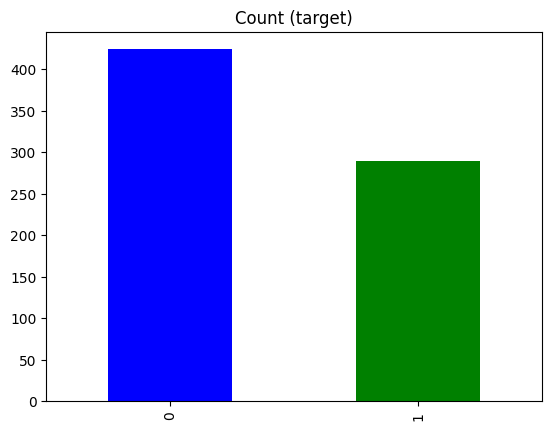

In [10]:
# Проверим сбалансированность данных
df.Survived.value_counts().plot(kind='bar', title='Count (target)', color = ['b', 'g'])

Баланс не идеальный, но какой-то дополнительной балансировки не требуется

## Обучение моделей

Разобъем наш датасет на выборки

In [11]:
x = df.drop('Survived', axis = 1)
y = df['Survived']
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25, random_state=14 )


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay


def try_model(model, x_train, y_train, x_test, y_test, model_params=None):
    if model_params is None:
        model_params = dict()
    print(model.__name__)
    pipeline = make_pipeline(StandardScaler(), model(**model_params))
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1 score:', f1_score(y_test, y_pred))
    print(y_pred)

    fpr, tpr, thresholds = roc_curve(y_test, pipeline.predict_proba(x_test)[:, 1])
    plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (area = {auc(fpr, tpr):0.3f})")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.legend()

    # for sklearn.__version__ of 1.0 and above
    # display = RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
    # display.plot()
    # plt.show()
    return pipeline

#### Для оценки мы будем использовать метрики Accuracy, Precision, Recall, F1 score и ROC curve в совокупности и будем оценивать эффективность обучения модели по минимальному значению из полученных

#### KNeighborsClassifier

KNeighborsClassifier
Accuracy: 0.8044692737430168
Precision: 0.7638888888888888
Recall: 0.7534246575342466
F1 score: 0.7586206896551725
[0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1
 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 1 1 1
 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 0 0 1 0
 0 0 1 1 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 1
 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0]


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

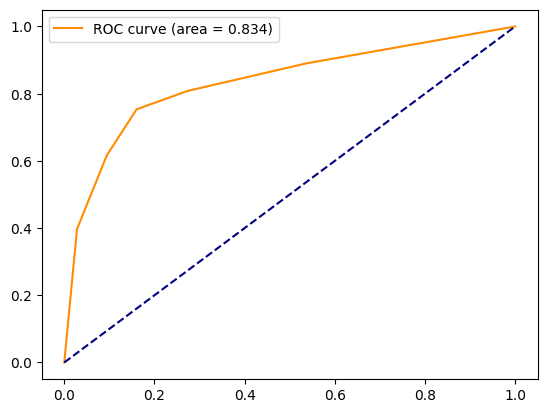

In [13]:
try_model(KNeighborsClassifier, x_train, y_train, x_test, y_test, model_params=dict(n_neighbors=5))

Минимальное значение из полученных - 0.75

#### GaussianNB

GaussianNB
Accuracy: 0.7821229050279329
Precision: 0.7428571428571429
Recall: 0.7123287671232876
F1 score: 0.7272727272727273
[1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1
 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1 1 1 1
 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0
 0 0 1 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0]


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])

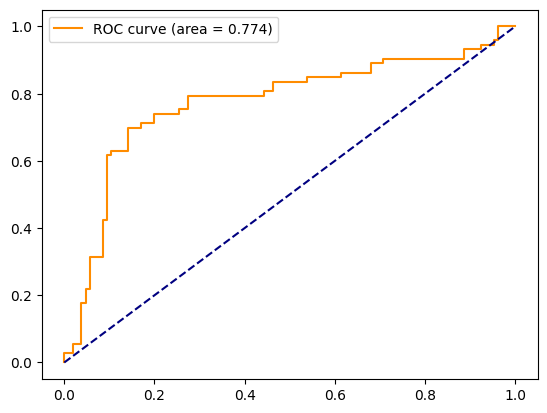

In [14]:
try_model(GaussianNB, x_train, y_train, x_test, y_test)

Минимальное значение из полученных - 0.71

#### LogisticRegression

LogisticRegression
Accuracy: 0.8156424581005587
Precision: 0.803030303030303
Recall: 0.726027397260274
F1 score: 0.7625899280575539
[0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1
 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1 1
 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0
 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0]


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

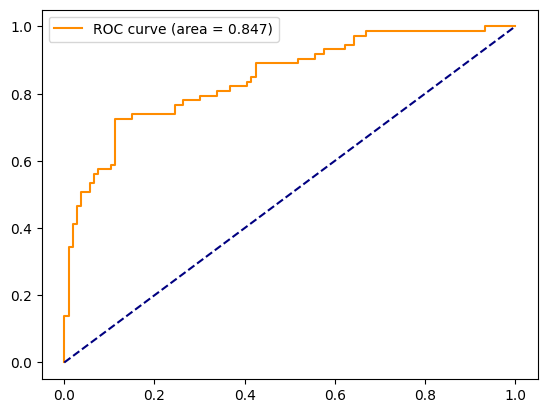

In [15]:
try_model(LogisticRegression, x_train, y_train, x_test, y_test)

Минимальное значение из полученных - 0.72

#### SVC

SVC
Accuracy: 0.8491620111731844
Precision: 0.8709677419354839
Recall: 0.7397260273972602
F1 score: 0.8
[0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1
 0 1 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0
 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0 0 0 1
 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0]


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(probability=True))])

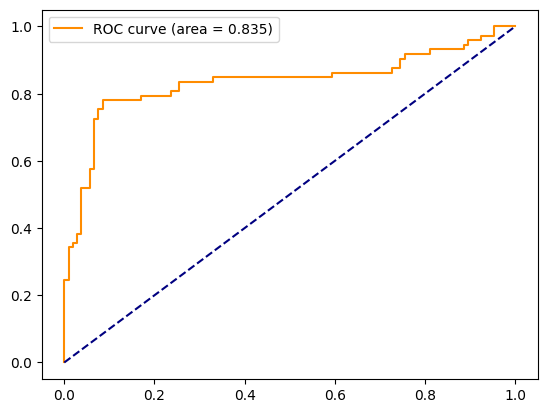

In [16]:
try_model(SVC, x_train, y_train, x_test, y_test,model_params=dict(
            probability=True,
))

Минимальное значение из полученных - 0.73

## Заключение
Лучший результат показала модель KNeighborsClassifier